# Logistic Regression Baseline

This notebook investigates multi-omics classification of TCGA BRCA tumors into PAM50 subtypes using regularized multinomial logistic regression. We first harmonize mRNA, DNA methylation, and RPPA data by intersecting patients and extracting consistent PAM50 labels, then explore each view with per-feature ANOVA and variance. Two feature-selection strategies are compared: (i) ANOVA eta^2-score ranking and (ii) simple variance-based ranking, applied either in an early integration setting (concatenated features with a single classifier) or in a late integration setting (view-specific classifiers whose probabilities are combined). For each model we estimate cross-validated performance (mean ± std of balanced accuracy) and report final test-set metrics (balanced accuracy, ROC-AUC, F1, confusion matrices), allowing a systematic comparison of integration and feature-selection strategies across views.

In [10]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from palettable import wesanderson as wes

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    balanced_accuracy_score,
    roc_auc_score,
    f1_score,
)
from sklearn.base import clone

# our utilities
from helpers_pre import (
    per_feature_anova_np,
    get_pam50,
    view_block_anova,
    view_block_mostVar,
    variance_score,
    per_feature_variance_np
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set(style="whitegrid")


### Load data

In [2]:
data_dir = "./../data/TCGA-BRCA/"
modalities = ["mRNA", "DNAm", "RPPA"]

data = {}
for omic in modalities:
    with open(f"{data_dir}{omic}.pkl", "rb") as f:
        data[omic] = pickle.load(f)

for omic in modalities:
    print(
        omic,
        "expr shape:",
        data[omic]["expr"].shape,
        "| meta shape:",
        data[omic]["meta"].shape,
    )


C:\Users\Petar\AppData\Local\Temp\ipykernel_51928\3528274444.py:7: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data[omic] = pickle.load(f)
C:\Users\Petar\AppData\Local\Temp\ipykernel_51928\3528274444.py:7: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access

mRNA expr shape: (500, 29995) | meta shape: (500, 7)
DNAm expr shape: (500, 100000) | meta shape: (500, 5)
RPPA expr shape: (500, 464) | meta shape: (500, 5)


C:\Users\Petar\AppData\Local\Temp\ipykernel_51928\3528274444.py:7: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data[omic] = pickle.load(f)


### Patient intersection across views

In [3]:
idx_mrna = set(data["mRNA"]["expr"].index)
idx_meth = set(data["DNAm"]["expr"].index)
idx_prot = set(data["RPPA"]["expr"].index)

patients_intersection = sorted(list(idx_mrna & idx_meth & idx_prot))
print(f"Expr intersection size: {len(patients_intersection)}")


Expr intersection size: 401


### PAM50 labels

In [4]:
pam_mrna = get_pam50(data, "mRNA")
pam_meth = get_pam50(data, "DNAm")
pam_prot = get_pam50(data, "RPPA")

pam_df = pd.concat([pam_mrna, pam_meth, pam_prot], axis=1)
pam_df = pam_df.reindex(patients_intersection)

pam50 = pam_df.bfill(axis=1).iloc[:, 0]
conflict_mask = pam_df.nunique(axis=1, dropna=True) > 1
n_conflicts = int(conflict_mask.sum())
if n_conflicts:
    print(
        f"Warning: {n_conflicts} patients have conflicting PAM50 labels "
        "(keeping mRNA > DNAm > RPPA)."
    )

pam50 = pam50.dropna()
patients = pam50.index.tolist()
print(f"Patients with PAM50 on expr-intersection: {len(patients)}")


Patients with PAM50 on expr-intersection: 401


### Building dataframes and label encoding

In [5]:
X_mrna = data["mRNA"]["expr"].loc[patients].values
X_meth = data["DNAm"]["expr"].loc[patients].values
X_prot = data["RPPA"]["expr"].loc[patients].values

y_str = pam50.astype(str).values

le = LabelEncoder()
y = le.fit_transform(y_str)
class_names = list(le.classes_)
print("PAM50 classes:", class_names)
print("Class counts:", np.bincount(y))

PAM50 classes: ['Basal', 'Her2', 'LumA', 'LumB']
Class counts: [ 61  28 230  82]


### Train/test split & per-view matrices

In [6]:
X_concat = np.hstack([X_mrna, X_meth, X_prot])
idx_all = np.arange(len(y))

idx_tr, idx_te = train_test_split(
    idx_all,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE,
)

Xtr_c, Xte_c = X_concat[idx_tr], X_concat[idx_te]
Xtr_m, Xte_m = X_mrna[idx_tr], X_mrna[idx_te]
Xtr_d, Xte_d = X_meth[idx_tr], X_meth[idx_te]
Xtr_p, Xte_p = X_prot[idx_tr], X_prot[idx_te]
y_tr, y_te = y[idx_tr], y[idx_te]

print("Train size:", len(y_tr), "Test size:", len(y_te))

Train size: 320 Test size: 81


### Per-feature ANOVA per view 

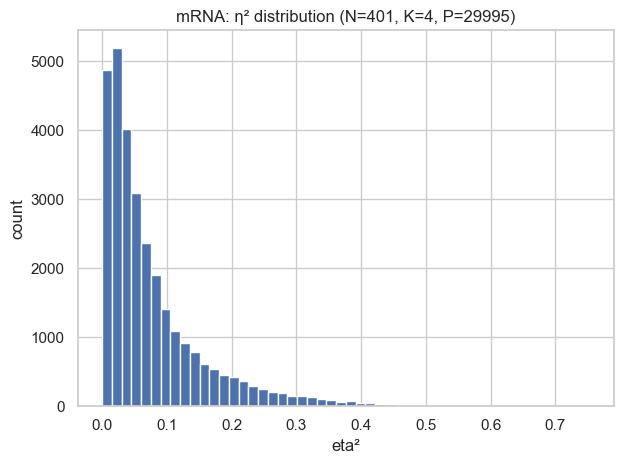

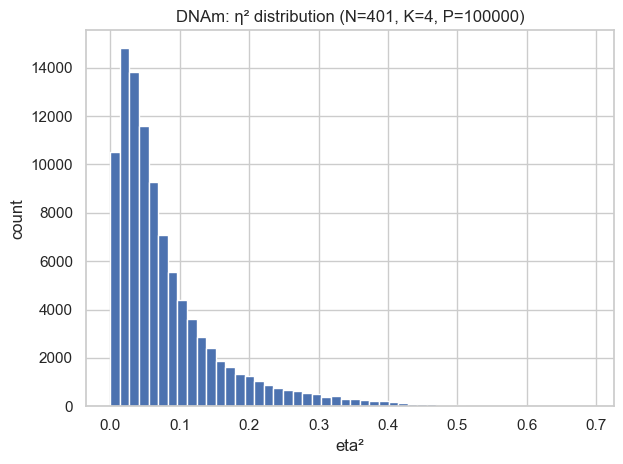

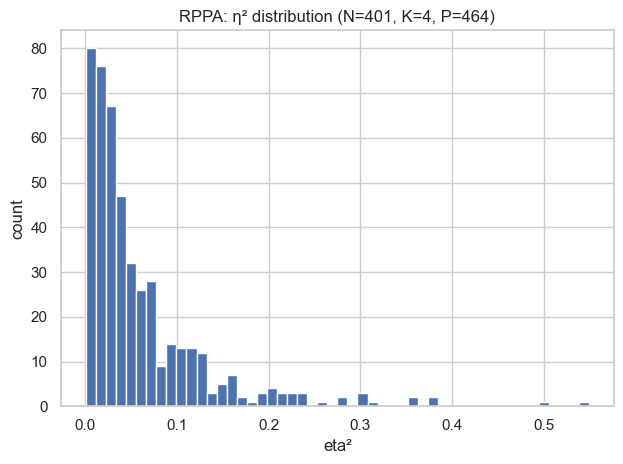

Features with eta2 > 0.2: 2623 8699 25


In [7]:
anova_mrna = per_feature_anova_np(X_mrna, y, "mRNA", plot=True)
anova_meth = per_feature_anova_np(X_meth, y, "DNAm", plot=True)
anova_prot = per_feature_anova_np(X_prot, y, "RPPA", plot=True)

K1 = (anova_mrna["eta2"] > 0.2).sum()
K2 = (anova_meth["eta2"] > 0.2).sum()
K3 = (anova_prot["eta2"] > 0.2).sum()
print("Features with eta2 > 0.2:", K1, K2, K3)

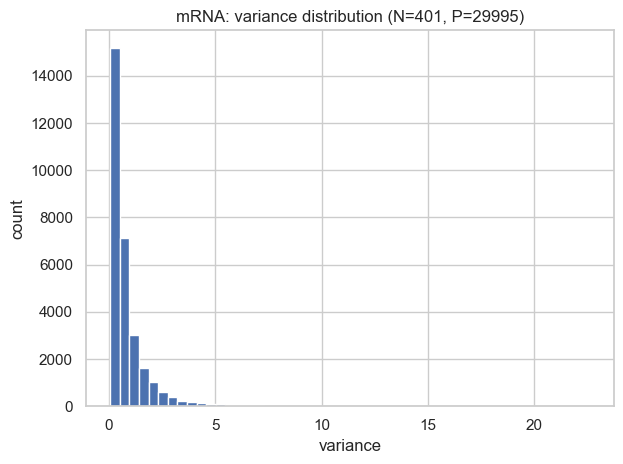

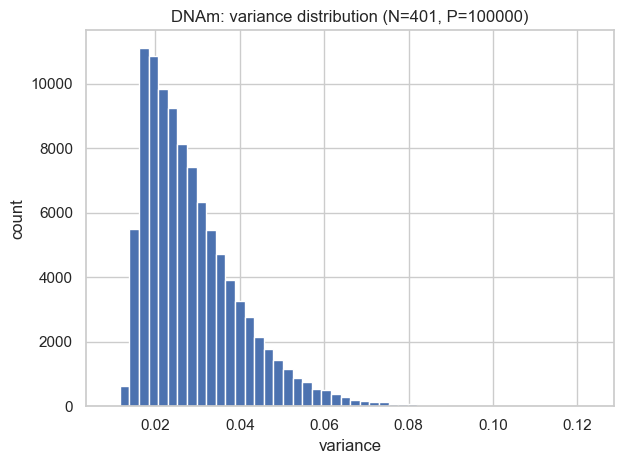

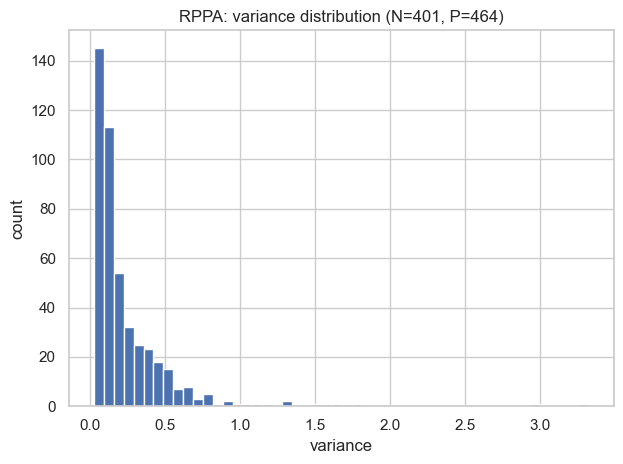

In [11]:
# Per-feature variance per view
var_mrna = per_feature_variance_np(X_mrna, "mRNA", plot=True)
var_meth = per_feature_variance_np(X_meth, "DNAm", plot=True)
var_prot = per_feature_variance_np(X_prot, "RPPA", plot=True)

### Helper: generic GridSearch + report

In [10]:
def run_gridsearch_and_report(
    name,
    pipeline,
    param_grid,
    Xtr,
    y_tr,
    Xte,
    y_te,
    cv,
):
    """
    Fit GridSearchCV with multiple scorings, print CV mean±std + test metrics.
    Returns the fitted GridSearchCV and predictions on test.
    """
    gs = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring={
            "bal_acc": "balanced_accuracy",
            "logloss": "neg_log_loss",
            "auc": "roc_auc_ovr_weighted",
        },
        refit="bal_acc",
        cv=cv,
        n_jobs=-1,
        verbose=2,
    )

    gs.fit(Xtr, y_tr)

    print(f"\n=== {name}: best params ===")
    print(gs.best_params_)

    best_idx = gs.best_index_
    for key, nice, negate in [
        ("bal_acc", "Balanced accuracy", False),
        ("auc", "ROC-AUC (OvR, weighted)", False),
        ("logloss", "Log-loss", True),
    ]:
        mean = gs.cv_results_[f"mean_test_{key}"][best_idx]
        std = gs.cv_results_[f"std_test_{key}"][best_idx]
        if negate:
            mean = -mean
        print(f"{nice} (CV): {mean:.3f} ± {std:.3f}")

    # test-set evaluation
    y_pred = gs.predict(Xte)
    proba = gs.predict_proba(Xte)

    print("\nTest balanced accuracy:", balanced_accuracy_score(y_te, y_pred).round(3))
    print(
        "Test ROC-AUC (OvR, weighted):",
        roc_auc_score(y_te, proba, multi_class="ovr", average="weighted").round(3),
    )
    print("\nClassification report (test):")
    print(classification_report(y_te, y_pred, target_names=class_names, digits=3))

    cm = confusion_matrix(y_te, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap="viridis", colorbar=True)
    plt.show()

    return gs, y_pred, proba


### Early integration, ANOVA-based selection

In [11]:
P1, P2, P3 = X_mrna.shape[1], X_meth.shape[1], X_prot.shape[1]
idx_mrna = list(range(0, P1))
idx_meth = list(range(P1, P1 + P2))
idx_prot = list(range(P1 + P2, P1 + P2 + P3))

# example K thresholds from eta^2 stats (or set manually)
K1_eta, K2_eta, K3_eta = 2623, 8699, P3   # adapt if you want
K_MRNA = min(K1_eta, P1)
K_METH = min(K2_eta, P2)
K_PROT = min(K3_eta, P3)

pre_anova = ColumnTransformer(
    transformers=[
        ("mrna", view_block_anova(K_MRNA), idx_mrna),
        ("meth", view_block_anova(K_METH), idx_meth),
        ("prot", view_block_anova(K_PROT), idx_prot),
    ],
    remainder="drop",
)

ef_anova = Pipeline(
    steps=[
        ("pre", pre_anova),
        (
            "clf",
            LogisticRegression(
                solver="saga",
                multi_class="multinomial",
                max_iter=5000,
                n_jobs=-1,
                random_state=RANDOM_STATE,
                class_weight="balanced",
            ),
        ),
    ]
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

param_grid_ef = {
    "clf__C": [0.01, 0.1, 1, 10, 100],
    "clf__penalty": ["l1", "l2"],
}

gs_ef_anova, y_pred_ef_anova, proba_ef_anova = run_gridsearch_and_report(
    name="Early integration (ANOVA)",
    pipeline=ef_anova,
    param_grid=param_grid_ef,
    Xtr=Xtr_c,
    y_tr=y_tr,
    Xte=Xte_c,
    y_te=y_te,
    cv=cv,
)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


KeyboardInterrupt: 

### Early integration, variance-based selection

In [12]:
pre_var = ColumnTransformer(
    transformers=[
        ("mrna", view_block_mostVar(K_MRNA), idx_mrna),
        ("meth", view_block_mostVar(K_METH), idx_meth),
        ("prot", view_block_mostVar(K_PROT), idx_prot),
    ],
    remainder="drop",
)

ef_var = Pipeline(
    steps=[
        ("pre", pre_var),
        (
            "clf",
            LogisticRegression(
                solver="saga",
                multi_class="multinomial",
                max_iter=5000,
                n_jobs=-1,
                random_state=RANDOM_STATE,
                class_weight="balanced",
            ),
        ),
    ]
)

gs_ef_var, y_pred_ef_var, proba_ef_var = run_gridsearch_and_report(
    name="Early integration (variance)",
    pipeline=ef_var,
    param_grid=param_grid_ef,
    Xtr=Xtr_c,
    y_tr=y_tr,
    Xte=Xte_c,
    y_te=y_te,
    cv=cv,
)


Fitting 5 folds for each of 10 candidates, totalling 50 fits



KeyboardInterrupt



### Late integration helper (CV mean±std + test)

In [13]:
def late_fusion_logreg(
    Xtr_views,
    Xte_views,
    y_tr,
    y_te,
    k_per_view,
    cv_outer,
    param_grid,
    use_variance=False,
):
    """
    Late fusion with per-view logistic regression models tuned via GridSearchCV
    over the same param grid (e.g. param_grid_ef).

    - Outer CV (cv_outer) gives mean ± std of late-fusion balanced accuracy.
    - For each outer fold and each view:
        * run GridSearchCV on the fold's training data
        * use best_estimator_ to predict probabilities on the fold's val data.
    - Then, refit per-view models on the full training set (with GridSearchCV)
      and evaluate late fusion on the held-out test set.
    """

    def make_base_view_pipeline(k):
        # ANOVA vs variance for feature ranking
        if use_variance:
            selector = SelectKBest(score_func=variance_score, k=k)
        else:
            selector = SelectKBest(score_func=f_classif, k=k)

        pipe = Pipeline(
            [
                ("scale", StandardScaler()),
                ("kbest", selector),
                (
                    "clf",
                    LogisticRegression(
                        solver="saga",
                        multi_class="multinomial",
                        class_weight="balanced",
                        max_iter=5000,
                        n_jobs=-1,
                        random_state=RANDOM_STATE,
                    ),
                ),
            ]
        )
        return pipe

    # --------------------------------------------------
    # 1) Outer CV: BA mean ± std for late fusion
    # --------------------------------------------------
    cv_scores = []

    for tr_idx, val_idx in cv_outer.split(Xtr_views["mRNA"], y_tr):
        Xm_tr, Xm_val = Xtr_views["mRNA"][tr_idx], Xtr_views["mRNA"][val_idx]
        Xd_tr, Xd_val = Xtr_views["DNAm"][tr_idx], Xtr_views["DNAm"][val_idx]
        Xp_tr, Xp_val = Xtr_views["RPPA"][tr_idx], Xtr_views["RPPA"][val_idx]
        y_tr_fold, y_val = y_tr[tr_idx], y_tr[val_idx]

        models_fold = {}

        # tune each view on the fold's training data
        for view_name, X_tr_view, k in [
            ("mRNA", Xm_tr, k_per_view["mRNA"]),
            ("DNAm", Xd_tr, k_per_view["DNAm"]),
            ("RPPA", Xp_tr, k_per_view["RPPA"]),
        ]:
            base_pipe = make_base_view_pipeline(k)
            gs_view = GridSearchCV(
                base_pipe,
                param_grid=param_grid,
                scoring="balanced_accuracy",
                cv=3,            # inner CV for that fold (can change)
                n_jobs=-1,
                refit=True,
                verbose=0,
            )
            gs_view.fit(X_tr_view, y_tr_fold)
            models_fold[view_name] = gs_view.best_estimator_

        # late fusion on validation fold
        logp = np.log(models_fold["mRNA"].predict_proba(Xm_val) + 1e-12)
        logp += np.log(models_fold["DNAm"].predict_proba(Xd_val) + 1e-12)
        logp += np.log(models_fold["RPPA"].predict_proba(Xp_val) + 1e-12)
        logp /= 3.0

        y_val_pred = logp.argmax(axis=1)
        cv_scores.append(balanced_accuracy_score(y_val, y_val_pred))

    cv_scores = np.array(cv_scores)
    print(
        f"Late fusion CV balanced accuracy: "
        f"{cv_scores.mean():.3f} ± {cv_scores.std():.3f}"
    )

    # --------------------------------------------------
    # 2) Refit per-view models on full training set,
    #    with the same grid, and evaluate on test set
    # --------------------------------------------------
    models_full = {}

    for view_name, X_tr_view, k in [
        ("mRNA", Xtr_views["mRNA"], k_per_view["mRNA"]),
        ("DNAm", Xtr_views["DNAm"], k_per_view["DNAm"]),
        ("RPPA", Xtr_views["RPPA"], k_per_view["RPPA"]),
    ]:
        base_pipe = make_base_view_pipeline(k)
        gs_view = GridSearchCV(
            base_pipe,
            param_grid=param_grid,
            scoring="balanced_accuracy",
            cv=cv_outer,      # use same outer CV splits for inner tuning
            n_jobs=-1,
            refit=True,
            verbose=1,
        )
        gs_view.fit(X_tr_view, y_tr)
        models_full[view_name] = gs_view.best_estimator_

        print(f"\nBest params for {view_name}: {gs_view.best_params_}")

    # late fusion on test set
    logp_test = np.log(models_full["mRNA"].predict_proba(Xte_views["mRNA"]) + 1e-12)
    logp_test += np.log(models_full["DNAm"].predict_proba(Xte_views["DNAm"]) + 1e-12)
    logp_test += np.log(models_full["RPPA"].predict_proba(Xte_views["RPPA"]) + 1e-12)
    logp_test /= 3.0

    y_pred_lf = logp_test.argmax(axis=1)

    print(
        "\nLate fusion test balanced accuracy:",
        balanced_accuracy_score(y_te, y_pred_lf).round(3),
    )
    print(
        "Late fusion test F1-weighted:",
        f1_score(y_te, y_pred_lf, average="weighted").round(3),
    )
    print("\nClassification report (test, late fusion):")
    print(classification_report(y_te, y_pred_lf, target_names=class_names, digits=3))

    cm = confusion_matrix(y_te, y_pred_lf)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap="viridis", colorbar=True)
    plt.show()

    return y_pred_lf, cv_scores


### Late integration (ANOVA vs variance)

In [ ]:
Xtr_views = {"mRNA": Xtr_m, "DNAm": Xtr_d, "RPPA": Xtr_p}
Xte_views = {"mRNA": Xte_m, "DNAm": Xte_d, "RPPA": Xte_p}
k_per_view = {"mRNA": K_MRNA, "DNAm": K_METH, "RPPA": K_PROT}

cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("=== Late fusion (ANOVA selection + grid search) ===")
y_pred_lf_anova, cv_scores_lf_anova = late_fusion_logreg(
    Xtr_views,
    Xte_views,
    y_tr,
    y_te,
    k_per_view=k_per_view,
    cv_outer=cv_outer,
    param_grid=param_grid_ef,   # <- same grid as early integration
    use_variance=False,
)

print("\n=== Late fusion (variance selection + grid search) ===")
y_pred_lf_var, cv_scores_lf_var = late_fusion_logreg(
    Xtr_views,
    Xte_views,
    y_tr,
    y_te,
    k_per_view=k_per_view,
    cv_outer=cv_outer,
    param_grid=param_grid_ef,   # <- same grid
    use_variance=True,
)
